In [1]:
from skimage.feature import register_translation
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
import scipy
import tensorflow as tf
from sopt.examples.utils import NearFieldPtychographySimulation
from sopt.examples.tensorflow.near_field_ptychography.tfPtycho import LMAPhaseRetriever
import sopt.benchmarks.ops.tensorflow.flops_registry_custom
from tensorflow.python.framework import graph_util
from sopt.benchmarks.ops.tensorflow.graph_utils_custom import get_flops_for_sub_graph, get_flops_for_node_list

W0926 14:22:15.498980 139859074193216 deprecation_wrapper.py:119] From /raid/home/skandel/code/sopt/sopt/benchmarks/ops/tensorflow/graph_utils_custom.py:14: The name tf.NodeDef is deprecated. Please use tf.compat.v1.NodeDef instead.

W0926 14:22:15.501080 139859074193216 deprecation_wrapper.py:119] From /raid/home/skandel/code/sopt/sopt/benchmarks/ops/tensorflow/graph_utils_custom.py:29: The name tf.GraphDef is deprecated. Please use tf.compat.v1.GraphDef instead.



In [2]:
%load_ext autoreload
%autoreload 2

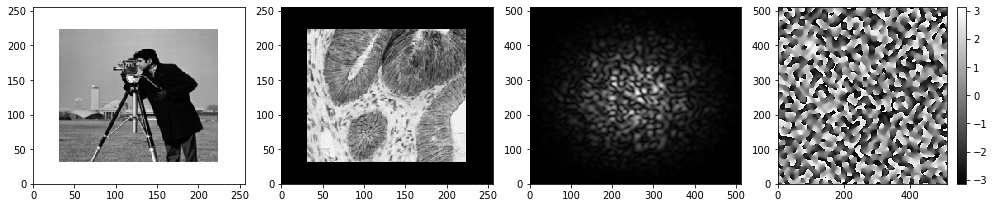

In [3]:
ptsim = NearFieldPtychographySimulation()

fig, axs = plt.subplots(1, 4, figsize=[14,3])
cax0 = axs[0].pcolormesh(np.abs(ptsim._obj_padded), cmap='gray')
cax1 = axs[1].pcolormesh(np.angle(ptsim._obj_padded), cmap='gray')
cax2 = axs[2].pcolormesh(np.abs(ptsim._probe_true), cmap='gray')
cax3 = axs[3].pcolormesh(np.angle(ptsim._probe_true), cmap='gray')
plt.colorbar(cax3)
plt.tight_layout()
plt.show()

## LMA - reconstructing both probe and object

In [4]:
pr_lma = LMAPhaseRetriever(ptsim=ptsim, probe_recons=True)
pr_lma.setOptimizingParams()
pr_lma.initSession()

W0926 14:22:30.585469 139859074193216 deprecation_wrapper.py:119] From /raid/home/skandel/code/sopt/sopt/examples/tensorflow/near_field_ptychography/tfPtycho.py:91: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0926 14:22:31.188638 139859074193216 deprecation.py:323] From /raid/home/skandel/miniconda3/envs/ad/lib/python3.7/site-packages/tensorflow/python/ops/clip_ops.py:157: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0926 14:22:31.198657 139859074193216 deprecation_wrapper.py:119] From /raid/home/skandel/code/sopt/sopt/examples/tensorflow/near_field_ptychography/tfPtycho.py:258: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W0926 14:22:31.207480 139859074193216 deprecation.py:323] From /raid/home/skandel/code/sopt/sopt/examples/tensorf

ValueError: Expected op/tensor name to start with gradients (excluding scope), got: obj_opt_gngvp/vjp/Complex_4_grad/Reshape:0. This means that a tf.gradients op with this op in its dependency path has a custom name that does not start with 'gradients'. Please make sure all calls to tf.gradients that have non-empty 'name' arguments use names that start with 'gradients'.

In [18]:
%%time
lma_obj_errors = []
lma_probe_errors = []
lma_losses = []
for i in tqdm(range(1000)):
    if i > 5: 
        _ = pr_lma.session.run(pr_lma.obj_minimize_op)
        _ = pr_lma.session.run(pr_lma._obj_clip_op)
    _ = pr_lma.session.run(pr_lma.probe_minimize_op)
    recons_obj, recons_probe, lossval = pr_lma.session.run([pr_lma._tf_obj_padded_cmplx, pr_lma._tf_probe_cmplx, pr_lma.loss_tensor])
    oshift, oerr, ophase = register_translation(recons_obj, ptsim._obj_padded, upsample_factor=10)
    oshift, oerr, ophase = register_translation(recons_obj * np.exp(-1j * ophase), ptsim._obj_padded, upsample_factor=10)
    pshift, perr, pphase = register_translation(recons_probe, ptsim._probe_true, upsample_factor=10)
    pshift, perr, pphase = register_translation(recons_probe * np.exp(-1j * pphase), ptsim._probe_true, upsample_factor=10)
    lma_obj_errors.append(oerr)
    lma_probe_errors.append(perr)
    lma_losses.append(lossval)
    if i % 10 == 0: print(i, lossval, oerr, perr)
    if oerr < 0.04: break

0 2853672200.0 0.5608027629293172 0.9932467279706715
10 365927740.0 0.40561322774178526 0.9897303335180866
20 250604800.0 0.4756905452123946 0.9860614075020909
30 218786290.0 0.47262537534469684 0.9815877246619945
40 201926600.0 0.45180480384255345 0.9760212178730673
50 187497360.0 0.4229727266750524 0.9680966097297427
60 170702720.0 0.380739084312597 0.9560840909187205
70 151044930.0 0.3328753872711716 0.9386636257607704
80 127375840.0 0.27973996566053283 0.9146154600742067
90 98075170.0 0.22476736955676574 0.8834382914305836
100 69970500.0 0.1629475036297895 0.8510907357995999
110 50566016.0 0.12772468923902425 0.825374658850265
120 37361530.0 0.10312451055784433 0.8040929857573064
130 27482864.0 0.08937895890891535 0.7848594388386627
140 20593896.0 0.08026844131507406 0.7682752077379487
150 17073484.0 0.0733145157364333 0.7540243154050608
160 14537859.0 0.06871308390673139 0.741109665500639
170 12697637.0 0.06486216473400672 0.729264179768831
180 11179651.0 0.06126773168462894 0.718

KeyboardInterrupt: 

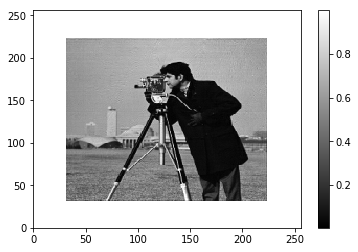

In [19]:
plt.figure(figsize=[8,3])
plt.subplot(1,2,1)
plt.pcolormesh(np.abs(recons_obj), cmap='gray')
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(np.angle(np.exp(1j * (np.angle(recons_obj)  - np.pi / 2))), cmap='gray')
plt.colorbar()
plt.show()

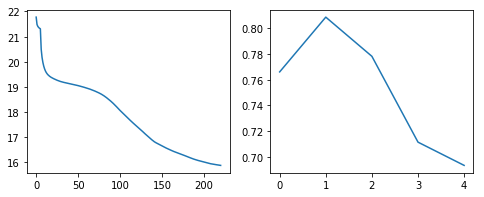

In [20]:
fig, axs = plt.subplots(1,2,figsize=[8,3])
axs[0].plot(np.log(lma_losses))
axs[1].plot(lma_errors)
plt.show()

In [21]:
with pr_lma.graph.as_default():
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()    
    flops_lma_and_fwd = tf.profiler.profile(run_meta=run_meta, cmd='scope', options=opts) 
    flops_lma_and_fwd = flops_lma_and_fwd.total_float_ops
    print(flops_lma_and_fwd)

Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes
33123795568


In [22]:
# To calculate the flops required for one conjugate gradient step (within the LMA routine),
# I am isolating the nodes involved in the conjugate gradient calculation.
# Since the conjugate gradient loop is self-contained, we can estimate the cost of
# each cg iteration in this fashion.
graph_def = pr_lma.graph.as_graph_def()
nodes_cg_obj = [node for node in graph_def.node if ('cg_while' in node.name) and ('obj' in node.name)]
flops_cg_obj = get_flops_for_node_list(pr_lma.graph, nodes_cg_obj)
nodes_cg_probe = [node for node in graph_def.node if ('cg_while' in node.name) and ('probe' in node.name)]
flops_cg_probe = get_flops_for_node_list(pr_lma.graph, nodes_cg_probe)

flops_cg_obj, flops_cg_probe

(4441421342, 4430214757)

In [23]:
obj_cg_iter_count = pr_lma.session.run(pr_lma._obj_optimizer._total_cg_iterations)
probe_cg_iter_count = pr_lma.session.run(pr_lma._probe_optimizer._total_cg_iterations)
outer_iterations = i #session.run(opt._iteration)

In [24]:
total_flops = (flops_lma_and_fwd * outer_iterations 
               + (obj_cg_iter_count - outer_iterations) * flops_cg_obj
               + (probe_cg_iter_count - outer_iterations) * flops_cg_probe)
print(f'total flops {total_flops:4.3g}')

total flops 4.42e+13
